In [1]:
import os
import getpass

# from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

from dotenv import load_dotenv
_ = load_dotenv()

# _set_env("ANTHROPIC_API_KEY")

llm = ChatOpenAI(model="gpt-4o")

In [2]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_N7jDVjvnt0xsv2JYC9gsKr2q',
  'type': 'tool_call'}]

In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

ValueError: Failed to render the graph using the Mermaid.INK API. Status code: 502.

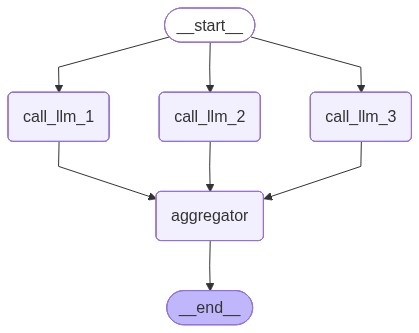

Here's a story, joke, and poem about cats!

STORY:
Once upon a time, in the quaint village of Whiskerwood, nestled between rolling hills and dense forests, there thrived a unique community of cats. These weren't ordinary cats; they were the descendants of the legendary Feline Council, known for their wisdom, courage, and the special bond they shared with the villagers.

In Whiskerwood, cats and humans lived in harmony, their lives intertwined in ways that brought joy to both. The cats, with their keen senses and astute minds, often helped the villagers solve problems, from predicting weather changes to finding lost items. In return, the villagers provided the cats with warmth, food, and endless affection.

At the heart of this feline society was an ancient oak tree, known as the Whispering Oak. Under its sprawling branches, the cats would gather every full moon to discuss matters of importance. The leader of the Feline Council, a venerable tabby named Elder Whiskers, was respected by a

In [6]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

In [5]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

ValueError: Failed to render the graph using the Mermaid.INK API. Status code: 502.

In [8]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

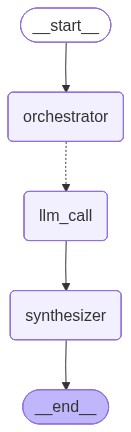

## Introduction to LLM Scaling Laws

Large Language Model (LLM) scaling laws are a set of empirical observations and theoretical principles that describe how the performance of language models improves as they increase in size, data, and computational resources. These laws are crucial in the field of artificial intelligence (AI) research as they provide insights into the relationship between model scale and capabilities, enabling researchers and engineers to make informed decisions about model development and deployment.

### Understanding LLM Scaling Laws

Scaling laws are derived from systematic experimentation and analysis, revealing patterns and trends that occur when models are scaled up. They typically involve key variables such as the number of model parameters, the amount of training data, and the computational budget. By examining how changes in these variables impact model performance, researchers can identify optimal strategies for model training and resource allocation.

### Significance in AI Research

The significance of LLM scaling laws is multifaceted:

1. **Performance Prediction**: Scaling laws allow researchers to predict the performance of LLMs before they are fully trained. This capability is invaluable for planning and optimizing resource use, reducing the trial-and-error approach traditionally needed in model development.

2. **Resource Allocation**: Understanding scaling laws enables better allocation of computational resources. Researchers can estimate the trade-offs between model size, training time, and data requirements, ensuring more efficient use of available resources.

3. **Architectural Insights**: Scaling laws provide insights into the architecture of language models. They help identify potential bottlenecks and guide the design of more efficient and scalable model architectures.

4. **Benchmarking and Evaluation**: These laws offer a framework for benchmarking different models and evaluating their performance relative to scale. This standardization aids in comparing advancements across the field.

### Predicting Performance with Scaling Laws

Scaling laws are used to project the improvements in tasks such as language understanding, generation, and translation as models grow. By extrapolating the observed trends from smaller models, researchers can estimate the performance of much larger models, predicting their capabilities and limitations.

This predictive power is crucial for long-term research planning and helps set realistic expectations for future developments in AI. It also informs the broader discussion about the ethical and practical implications of deploying ever-larger language models, as understanding their potential capabilities and limitations becomes increasingly important.

In summary, LLM scaling laws are a foundational aspect of modern AI research, offering vital insights into the development and optimization of large language models. Their application not only accelerates the advancement of AI technologies but also ensures that resources are utilized effectively, pushing the boundaries of what is possible with language models.

---

### Historical Background and Development

The journey of scaling laws in artificial intelligence (AI) has been marked by a series of pivotal discoveries and developments that have profoundly influenced the field. This section explores the historical context and key milestones that have shaped the current understanding of scaling laws in AI, highlighting the contributions of seminal researchers and the evolution of core ideas.

#### Early Foundations

The concept of scaling in computational systems can trace its roots back to the mid-20th century when researchers began exploring the relationship between the size of computational models and their performance capabilities. Initial investigations focused on basic neural networks, inspired by the biological processes of the human brain, and their potential scalability to perform complex tasks.

During this period, researchers such as Marvin Minsky and Seymour Papert conducted foundational work on perceptrons, revealing the limitations of simple linear models. Their insights underscored the necessity of scaling model complexity to achieve more sophisticated AI systems.

#### Emergence of Deep Learning

The resurgence of interest in neural networks in the 1980s and 1990s, fueled by advancements in computational power and algorithmic innovations, set the stage for significant developments in scaling laws. Key figures such as Geoffrey Hinton, Yann LeCun, and Yoshua Bengio pioneered deep learning techniques, demonstrating the efficacy of multi-layered networks in learning complex patterns from large datasets.

The advent of deep learning marked a turning point, as researchers began to systematically investigate the effects of scaling model size, dataset size, and computational resources on performance. This era saw the introduction of convolutional neural networks (CNNs) and recurrent neural networks (RNNs), which laid the groundwork for modern AI architectures.

#### Scaling Laws in the 21st Century

In the early 21st century, the rapid growth of available data and computational resources facilitated a deeper exploration of scaling laws. The introduction of models such as AlexNet by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton in 2012 demonstrated how scaling up neural networks could achieve unprecedented accuracy in image classification tasks.

Subsequent milestones included the development of transformer models, first introduced in the seminal paper "Attention is All You Need" by Vaswani et al. in 2017. Transformers exemplified the power of scaling both model size and training data, leading to breakthroughs in natural language processing (NLP) and setting new standards in AI performance.

#### Key Contributions and Impact

Researchers have continued to refine the understanding of scaling laws, with significant contributions from OpenAI and Google Brain. The GPT series of models, including GPT-2 and GPT-3, underscored the exponential improvements achievable through scaling, prompting further exploration into efficient scaling strategies and their limits.

The work of researchers such as Tomas Mikolov in word embeddings and Ian Goodfellow in generative adversarial networks (GANs) has also been instrumental in advancing scaling methodologies. These contributions have not only enhanced the capabilities of AI systems but have also sparked discussions on the ethical and practical implications of deploying large-scale AI models.

#### Conclusion

The historical development of scaling laws in AI reflects a trajectory of continuous innovation and exploration. From the early theoretical insights of neural network capabilities to the transformative impact of deep learning and modern large-scale models, the field has been shaped by a dedicated community of researchers. As AI continues to evolve, understanding and leveraging scaling laws remain crucial for future advancements, guiding the design of more efficient and powerful AI systems.

---

### Mathematical Foundations

Scaling laws are mathematical relationships that describe how different properties of a system change with size. These laws are crucial in various scientific fields, including physics, biology, and economics, as they provide insights into the behavior of systems as they scale up or down. The mathematical foundations of scaling laws involve several key principles and models, which are described below.

#### Power Laws

At the heart of scaling laws is the concept of power laws, which are expressed in the form:

\[ y = ax^k \]

where:
- \( y \) is the dependent variable,
- \( x \) is the independent variable,
- \( a \) is a constant,
- \( k \) is the scaling exponent.

Power laws are characterized by their scale invariance, meaning they have the same form regardless of the scale at which they are observed. This property makes them particularly useful for describing phenomena across different scales.

#### Dimensional Analysis

Dimensional analysis is a mathematical technique used to understand the relationships between different physical quantities by considering their dimensions. It involves the use of dimensionless numbers to simplify complex systems into more manageable forms. Buckingham's Pi theorem is a central tool in dimensional analysis and states that any physically meaningful equation involving \( n \) variables can be reduced to a relationship between \( n - m \) dimensionless parameters, where \( m \) is the number of fundamental dimensions involved.

#### Fractals and Self-Similarity

Fractals are structures that exhibit self-similarity at different scales. The mathematical foundation of fractals is based on recursive patterns and can be described by equations such as:

\[ N(s) = C \cdot s^{-D} \]

where:
- \( N(s) \) is the number of self-similar pieces of size \( s \),
- \( C \) is a constant,
- \( D \) is the fractal dimension.

Self-similarity is a key property in many natural and artificial systems and is essential for understanding phenomena such as coastlines, market fluctuations, and biological growth patterns.

#### Statistical Mechanics and Renormalization Group Theory

Statistical mechanics provides a framework for understanding the macroscopic properties of systems from their microscopic interactions. Scaling laws often emerge in the context of critical phenomena, where systems exhibit scale invariance near critical points. Renormalization group theory is a mathematical approach used to study changes in a physical system as it is viewed at different scales. It provides insights into the universality of scaling laws and helps explain why systems with different microscopic details can exhibit similar macroscopic behavior.

#### Network Theory

In network theory, scaling laws describe the growth and structure of networks. The degree distribution of many real-world networks follows a power law, indicating the presence of hubs with many connections. The Barabási-Albert model is a well-known model that explains the emergence of scale-free networks through preferential attachment, where new nodes are more likely to connect to existing nodes with a higher degree.

### Conclusion

The mathematical foundations of scaling laws encompass a diverse array of concepts and models. Understanding these principles is essential for interpreting the complex behaviors of systems across different scales. By leveraging power laws, dimensional analysis, fractals, statistical mechanics, and network theory, researchers can uncover the underlying patterns that govern the dynamics of various phenomena.

---

## Empirical Evidence and Case Studies

The development and scaling of large language models (LLMs) have been subjects of intensive research, with empirical evidence and case studies providing insights into the scaling laws that govern their performance. As LLMs have grown in size and complexity, several key trends have emerged, underscoring the relationship between model scale and various performance metrics.

### Scaling Laws in Large Language Models

Empirical studies have highlighted that as LLMs increase in size—both in terms of parameters and data—they exhibit improved capabilities across a range of tasks. A notable contribution to this understanding is the "scaling laws" framework, which mathematically describes how performance metrics such as test loss, training time, and computational requirements vary with model size. These laws suggest that doubling the model size leads to consistent improvements in performance, albeit with diminishing returns as the model continues to scale.

### Case Studies on Scaling LLMs

#### GPT-3 by OpenAI

One of the most prominent case studies is OpenAI's GPT-3, which demonstrated the potential of scaling LLMs to unprecedented sizes. With 175 billion parameters, GPT-3 showcased significant advancements in language understanding and generation, outperforming smaller predecessors across various benchmarks. The scaling of GPT-3 not only improved task performance but also enabled new capabilities, such as zero-shot and few-shot learning, where the model could perform tasks with little to no task-specific training data.

#### BERT and Its Variants

The BERT model and its scaled variants, such as RoBERTa and ALBERT, further exemplify the benefits of scaling. These models, when scaled in terms of both data and parameters, have achieved state-of-the-art results on numerous natural language processing (NLP) benchmarks. Notably, the case of RoBERTa, which increased the size of training data and adjusted hyperparameters without altering model architecture, highlighted that scaling data can be as crucial as scaling model parameters.

#### DeepMind's Gopher

DeepMind's Gopher model is another crucial case study in the scaling of LLMs. With 280 billion parameters, Gopher was designed to test the limits of scaling laws further. The findings from Gopher's deployment indicated that larger models consistently outperform smaller models in terms of language understanding and generation tasks. However, the study also pointed out the challenges associated with scaling, such as increased computational resources and energy consumption.

### Impact of Scaling on Model Capabilities

The empirical evidence from these case studies suggests that scaling laws provide a reliable framework for predicting the improvements in LLM capabilities as models grow larger. However, these improvements are not without challenges. As models scale, issues such as fairness, bias, and the interpretability of LLMs become increasingly significant. Moreover, the environmental impact of training large models has raised concerns about sustainability.

### Conclusion

The empirical evidence and case studies reviewed herein illustrate that scaling laws are pivotal in understanding the dynamics of LLM performance improvement. By examining past projects like GPT-3, BERT, and Gopher, we gain valuable insights into the benefits and challenges of scaling, informing future advancements in the field. As researchers continue to push the boundaries of LLMs, these scaling laws will remain an essential guide in optimizing model architectures and training methodologies.

---

### Challenges and Limitations

The application of scaling laws in predictive modeling has gained significant traction in recent years, offering a framework to understand how changes in model size and data impact performance. Despite their utility, several challenges and limitations accompany their use, often sparking debate and criticism within the research community.

#### Overgeneralization

One of the primary criticisms of scaling laws is the risk of overgeneralization. Scaling laws often derive from observations on specific datasets and models, leading to assumptions that these laws universally apply. This can result in models that perform well in controlled environments but falter in real-world applications where data distributions and complexities differ markedly.

#### Data and Computational Constraints

Implementing scaling laws effectively requires vast amounts of data and computational resources. This presents a significant barrier to entry, limiting the ability of smaller organizations to leverage these models. The computational intensity not only requires substantial financial investment but also raises concerns about environmental sustainability due to the high energy consumption of training large models.

#### Diminishing Returns

Another limitation is the phenomenon of diminishing returns. As models and datasets scale, the marginal gains in performance tend to decrease. This poses a question of efficiency and practicality, as the additional resources required may not justify the incremental improvements in model performance, particularly in niche applications where high precision is not critical.

#### Lack of Interpretability

Scaling laws often emphasize empirical performance metrics without providing insights into why certain models perform better. This lack of interpretability can hinder trust and adoption, particularly in domains where understanding the decision-making process is crucial, such as healthcare and finance.

#### Sensitivity to Hyperparameters

The effectiveness of scaling laws is sensitive to hyperparameter settings, which can vary widely across different implementations. This sensitivity introduces variability that can obscure the true scalability of a model, leading to misleading conclusions about its performance potential.

#### Robustness and Generalization

Models developed under the guidance of scaling laws may exhibit robustness in controlled test settings but fail to generalize to unseen data or adversarial conditions. This raises concerns about the reliability of these models in real-world applications, where unexpected inputs and conditions are the norm.

#### Ethical and Societal Implications

Reliance on scaling laws can exacerbate existing biases present in training data, leading to models that reinforce stereotypes or make unfair predictions. The scaling of models without thorough consideration of ethical implications can, therefore, result in societal harm, reinforcing the need for rigorous bias evaluation and mitigation strategies.

#### Conclusion

While scaling laws provide a valuable lens through which to view model development, their application is fraught with challenges and limitations. Researchers and practitioners must carefully consider these factors to avoid overreliance on scaling laws, ensuring that models are both effective and ethical in their deployment. Future work should focus on addressing these limitations, particularly in terms of improving interpretability, reducing resource demands, and ensuring fairness and robustness in model predictions.

---

## Future Directions and Research Opportunities

As the field of artificial intelligence continues to advance, scaling laws remain a critical area of study that promises to enhance our understanding of model performance and efficiency. The future directions for scaling laws research are both exciting and pivotal, as they have the potential to influence the trajectory of AI technology development significantly.

### Advancements in Scaling Laws

One of the key areas for future advancements in scaling laws is the refinement of existing models to better predict the performance of AI systems as they scale. This involves developing more sophisticated mathematical frameworks that can accurately capture the complexities and nuances of larger models, particularly in terms of their computational and resource requirements. Future research could focus on integrating factors such as hardware optimizations, data availability, and algorithmic innovations to create more comprehensive scaling laws.

### Exploring New Dimensions

Scaling laws have traditionally focused on parameters like model size, data size, and compute power. However, future research could explore additional dimensions, such as the role of network architecture, optimization techniques, and their interaction with scaling properties. Understanding how these factors influence scaling behavior could lead to more efficient model designs that maximize performance while minimizing resource usage.

### Evolving with AI Technology

As AI technology evolves, scaling laws must adapt to new paradigms and breakthroughs. This includes the integration of emerging technologies such as quantum computing, neuromorphic engineering, and bio-inspired computing into scaling law frameworks. These technologies have the potential to alter the fundamental principles of scaling, necessitating the development of new theories and models that can accurately describe their effects.

### Interdisciplinary Approaches

The progression of scaling laws research could benefit greatly from interdisciplinary approaches that combine insights from fields such as physics, biology, and economics. By leveraging methodologies and theories from these disciplines, researchers can gain a deeper understanding of the underlying principles that govern scaling in natural and artificial systems. This cross-disciplinary collaboration could lead to the discovery of universal scaling laws that apply across different domains.

### Ethical and Societal Implications

As scaling laws drive the development of increasingly powerful AI systems, it is crucial to consider the ethical and societal implications of these advancements. Future research should address questions related to the responsible scaling of AI, including the potential for bias amplification, environmental impact, and the equitable distribution of technological benefits. By incorporating ethical considerations into scaling laws research, we can ensure that the development of AI technology aligns with societal values and priorities.

### Conclusion

The exploration of future directions and research opportunities in scaling laws is vital for the continued advancement of AI technology. By refining existing models, exploring new dimensions, and adapting to technological innovations, researchers can unlock new levels of AI performance and efficiency. Interdisciplinary approaches and a focus on ethical considerations will be key to ensuring that scaling laws contribute positively to the development of AI and its integration into society.

---

## Conclusion

In this report, we have explored the intricate dynamics and implications of scaling laws as they pertain to large language models and the broader AI research landscape. Our analysis underscores several key points that are pivotal for understanding the trajectory of AI advancements.

Firstly, scaling laws reveal that as models increase in size, they tend to exhibit enhanced performance across a variety of tasks, suggesting that bigger models inherently possess greater potential to understand and generate human-like text. This trend is central to the ongoing development of AI and has significant implications for both academic research and industry applications.

Secondly, while the benefits of scaling are evident, they also introduce a set of challenges that must be addressed. The computational and financial costs associated with creating and maintaining larger models are substantial, raising concerns about accessibility and sustainability in AI research. This necessitates a balanced approach that considers not only the benefits of scaling but also the environmental and ethical implications.

Moreover, the continued reliance on scaling as a primary strategy for improving model performance may limit the exploration of alternative methodologies that could lead to more efficient and innovative breakthroughs. Encouraging a diversity of approaches in model development could foster more sustainable advancements in AI.

Finally, the implications of scaling laws extend beyond technical considerations, influencing how AI is integrated into society. As language models become more powerful, issues related to bias, fairness, and transparency become increasingly relevant. Researchers and developers must prioritize these considerations to ensure that AI systems are not only capable but also equitable and trustworthy.

In conclusion, while scaling laws have significantly contributed to the rapid progression of AI capabilities, the path forward must be navigated with careful consideration of both the technical and societal impacts. By addressing the challenges and embracing a multifaceted approach to AI research, we can harness the full potential of large language models to contribute positively to society.

In [9]:
from langgraph.types import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

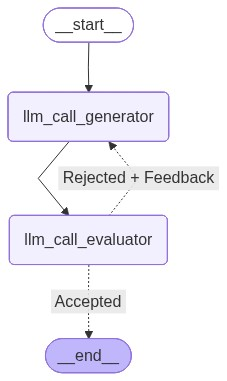

Why did the cat sit on the computer?

Because it wanted to keep an eye on the mouse!


In [10]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

In [11]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

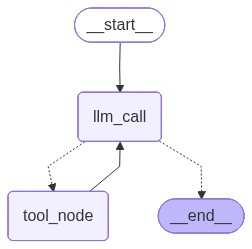

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_FivezD2hdVG3fIE3hF7CNiaN)
 Call ID: call_FivezD2hdVG3fIE3hF7CNiaN
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [12]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()